# Analysis of Vaghari's MEG dataset
This Jupyter notebook computes 1/f slopes and E/I predictions from resting-state MEG recordings of MCI patients and healthy controls included in the Vaghari's MEG dataset [1].

[1] Vaghari, D., R. Bruna, L. E. Hughes, D. Nesbitt, R. Tibon, J. B. Rowe, F. Maestu, and R. N. Henson. 2022. "A multi-site, multi-participant magnetoencephalography resting-state dataset to study dementia: The BioFIND dataset." Neuroimage 258: 119344. https://doi.org/10.1016/j.neuroimage.2022.119344

In [1]:
import numpy as np
import sys,os
import scipy
from scipy import stats
import scipy.io as sio
import matplotlib.pyplot as plt
from matplotlib import rcParams
import multiprocessing as mp
import pickle
import pandas as pd
import tools

In [2]:
def compute_slopes(data):
    '''
    Compute 1/f slopes from neural power spectra.
    
    Parameters
    ----------
    data: list
    data[0]: list of numpy arrays
        Collection of power spectra to be processed.
    data[1]: list, numpy array
        Frequencies of power spectrum.
    data[2]: dict
        Parameters of the algorithm for parameterizing neural power spectra.
        
    Returns
    ----------
    slopes: list
    '''
    # Unpack data
    PSD_data = data[0]
    fx = data[1]
    fit_parameters = data[2]
    # Output array
    estimator_data = []

    for spectrum in PSD_data:
        # Run the fitting algorithm
        fit_results = tools.power_spectrum_fit(fx,spectrum,fit_parameters)

        if len(fit_results) > 1:
            # Collect 1/f slope
            estimator_data.append(fit_results[0][1])

    return estimator_data

Select between computing 1/f slopes (**'compute'**) or loading slopes from file (**'load'**). If *slopes_compute = compute*, *data_path* must contain the folder location with the ROI time-series data. To compute ROI data from the Biofind MEG recordings, I have run the following script from the Github BioFind repository [2] in the DPUK Data Portal:
* **preproc_beamform_ROI.m** (processing only MEG recordings from > 75 year old participants)

[2] The BioFIND Github repository: https://github.com/delshadv/BioFIND-data-paper

In [3]:
slopes_compute = 'load'

In [4]:
if slopes_compute == 'compute':
    # Get all file names of ROI data from > 75 year old participants
    data_path = 'P:/pablomartinezcanada/BioFIND'
    ldir = os.listdir(data_path+'/ROIs_older_75/')
    ldir.sort()

    # Power spectra: MCI (converters and non-converters) and control
    MCI_conv_spectra = [[] for k in range(38)] # 38 ROIs
    MCI_non_spectra = [[] for k in range(38)] 
    control_spectra = [[] for k in range(38)] 

    # Load participants' info
    participants_imputed = pd.read_csv(data_path+'/code/participants-imputed.tsv',
                                       sep = '\t')

    # Number of participants of each group and recording site used in this study
    N_control_site_1 = 0
    N_control_site_2 = 0
    N_MCI_conv_site_1 = 0
    N_MCI_conv_site_2 = 0
    N_MCI_non_site_1 = 0
    N_MCI_non_site_2 = 0

    # Process MEG data
    for k,file in enumerate(ldir):
        data = sio.loadmat(data_path+'/ROIs_older_75/'+file)['g']

        # Print participants' info
        group = np.array(participants_imputed.loc[
            participants_imputed['participant_id'] == file[0:-4]]['group'])[0]
        converter = np.array(participants_imputed.loc[
            participants_imputed['participant_id'] == file[0:-4]]['Converters'])[0]
        site = np.array(participants_imputed.loc[
            participants_imputed['participant_id'] == file[0:-4]]['site'])[0]
        age = np.array(participants_imputed.loc[
            participants_imputed['participant_id'] == file[0:-4]]['age'])[0]
        print("\n\nFile: %s, Group: %s, Converter: %s, Site: %s, age: %s. "+\
              "Progress: %.0f%%\n" % (file,group,converter,site,age,
                                      float(100. * ((k+1)/len(ldir)))))

        # Compute power spectrum for each ROI and data segment
        for ROI in range(data.shape[0]):
            for segment in range(10): # Pick the first 10 segments (same number
                                      # of segments for all participants)
                # Spectrogram
                fx, t, Dxx = scipy.signal.spectrogram(data[ROI,:,segment],fs = 500.,
                                                window = ('kaiser',6),nperseg = 500,
                                                noverlap = 250) # 1-s window, 
                                                                # 50 % overlapping
                # Average across spectrogram times to compute power spectrum
                spectrum = np.median(Dxx,axis = 1)

                # To avoid division by 0
                fx[0] = 10 ** (-10)

                # Normalization in the (1,40) Hz range
                spectrum /= np.mean(spectrum[1:41])

                # MCI
                if group == 'patient':
                    # Converter
                    if converter == 1:
                        MCI_conv_spectra[ROI].append(spectrum)
                        # Increase count
                        if site == 1 and ROI == 0 and segment == 0:
                            N_MCI_conv_site_1 += 1
                        if site == 2 and ROI == 0 and segment == 0:
                            N_MCI_conv_site_2 += 1
                    # Non-converter
                    if converter == 0:
                        MCI_non_spectra[ROI].append(spectrum)
                        # Increase count
                        if site == 1 and ROI == 0 and segment == 0:
                            N_MCI_non_site_1 += 1
                        if site == 2 and ROI == 0 and segment == 0:
                            N_MCI_non_site_2 += 1

                # Control
                if group == 'control':
                    control_spectra[ROI].append(spectrum)
                    # Increase count
                    if site == 1 and ROI == 0 and segment == 0:
                        N_control_site_1 += 1
                    if site == 2 and ROI == 0 and segment == 0:
                        N_control_site_2 += 1

    # Print counts
    print("N_control_site_1 = %s" % N_control_site_1)
    print("N_control_site_2 = %s " % N_control_site_2)
    print("N_MCI_conv_site_1 = %s" % N_MCI_conv_site_1)
    print("N_MCI_conv_site_2 = %s" % N_MCI_conv_site_2)
    print("N_MCI_non_site_1 = %s" % N_MCI_non_site_1)
    print("N_MCI_non_site_2 = %s" % N_MCI_non_site_2)

# Parameters of the algorithm for parameterizing neural power spectra
fit_parameters = {
    'freq_range_FOOOF_fitting': [1.,40.], # Hz
    'FOOOF_max_n_peaks': 3,
    'FOOOF_peak_width_limits': [2.,50.], # Hz
    'FOOOF_peak_threshold': 1.
}

# Compute slopes
if slopes_compute == 'compute':
    # Datasets of slopes
    MCI_conv_slopes = [[] for k in range(38)] # 38 ROIs
    MCI_non_slopes = [[] for k in range(38)] 
    control_slopes = [[] for k in range(38)] 

    # Multiprocessing (8 threads)
    # MCI_conv
    input_data = []
    # Pool of processes that we want to run
    pool = mp.Pool(8)
    ROIs_completed = [0]
    # Arrange input data
    for ROI in range(38):
        f_args = []
        f_args.append(MCI_conv_spectra[ROI])
        f_args.append(fx)
        f_args.append(fit_parameters)
        input_data.append(f_args)
    # Distribute jobs
    for ROI,result in enumerate(pool.map(compute_slopes,input_data)):
        MCI_conv_slopes[ROI] = np.array(result)
        # show progress
        ROIs_completed[0]+=1
        print("MCI_conv - Computing slopes. Progress: %.0f%% \n" % (
                                    100*(ROIs_completed[0]/38)))
    # Close pool
    pool.close()

    # MCI_non
    input_data = []
    # Pool of processes that we want to run
    pool = mp.Pool(8)
    ROIs_completed = [0]
    # Arrange input data
    for ROI in range(38):
        f_args = []
        f_args.append(MCI_non_spectra[ROI])
        f_args.append(fx)
        f_args.append(fit_parameters)
        input_data.append(f_args)
    # Distribute jobs
    for ROI,result in enumerate(pool.map(compute_slopes,input_data)):
        MCI_non_slopes[ROI] = np.array(result)
        # show progress
        ROIs_completed[0]+=1
        print("MCI_non - Computing slopes. Progress: %.0f%% \n" % (
                                        100*(ROIs_completed[0]/38)))
    # Close pool
    pool.close()

    # control
    input_data = []
    # Pool of processes that we want to run
    pool = mp.Pool(8)
    ROIs_completed = [0]
    # Arrange input data
    for ROI in range(38):
        f_args = []
        f_args.append(control_spectra[ROI])
        f_args.append(fx)
        f_args.append(fit_parameters)
        input_data.append(f_args)
    # Distribute jobs
    for ROI,result in enumerate(pool.map(compute_slopes,input_data)):
        control_slopes[ROI] = np.array(result)
        # show progress
        ROIs_completed[0]+=1
        print("control - Computing slopes. Progress: %.0f%% \n" % (
                                        100*(ROIs_completed[0]/38)))
    # Close pool
    pool.close()

    # Create directories to save datasets
    if not os.path.isdir('slopes'):
        os.mkdir('slopes')
    if not os.path.isdir('slopes/BioFind_data'):
        os.mkdir('slopes/BioFind_data')
    if not os.path.isdir('spectra'):
        os.mkdir('spectra')
    if not os.path.isdir('spectra/BioFind_data'):
        os.mkdir('spectra/BioFind_data')

    # Save data
    pickle.dump(MCI_conv_slopes,open("slopes/BioFind_data/MCI_conv_slopes","wb") )
    pickle.dump(MCI_non_slopes,open("slopes/BioFind_data/MCI_non_slopes","wb") )
    pickle.dump(control_slopes,open("slopes/BioFind_data/control_slopes","wb") )
    pickle.dump(MCI_conv_spectra,open("spectra/BioFind_data/MCI_conv_spectra","wb") )
    pickle.dump(MCI_non_spectra,open("spectra/BioFind_data/MCI_non_spectra","wb") )
    pickle.dump(control_spectra,open("spectra/BioFind_data/control_spectra","wb") )
    pickle.dump(fx,open("spectra/BioFind_data/fx","wb") )

# Load slopes and power spectra from file
else:
    # Untar control spectra
    os.system('cat spectra/BioFind_data/control_spectra.bz2.parta*>'+\
              'spectra/BioFind_data/control_spectra.bz2')
    os.system('tar -xf spectra/BioFind_data/control_spectra.bz2 -C spectra/BioFind_data/')
    # Load data
    MCI_conv_slopes = pickle.load(open("slopes/BioFind_data/MCI_conv_slopes","rb") )
    MCI_non_slopes = pickle.load(open("slopes/BioFind_data/MCI_non_slopes","rb") )
    control_slopes = pickle.load(open("slopes/BioFind_data/control_slopes","rb") )
    MCI_conv_spectra = pickle.load(open("spectra/BioFind_data/MCI_conv_spectra","rb") )
    MCI_non_spectra = pickle.load(open("spectra/BioFind_data/MCI_non_spectra","rb") )
    control_spectra = pickle.load(open("spectra/BioFind_data/control_spectra","rb") )
    fx = pickle.load(open("spectra/BioFind_data/fx","rb") )
    # remove bz2 file
    os.system('rm spectra/BioFind_data/control_spectra.bz2')

Define properties of figures to plot.

In [5]:
DPI = 300
rcParams['font.family'] = 'Arial'
rcParams['font.size'] = 10

Create and plot Figure 2 and supplementary figures 2 and 3.

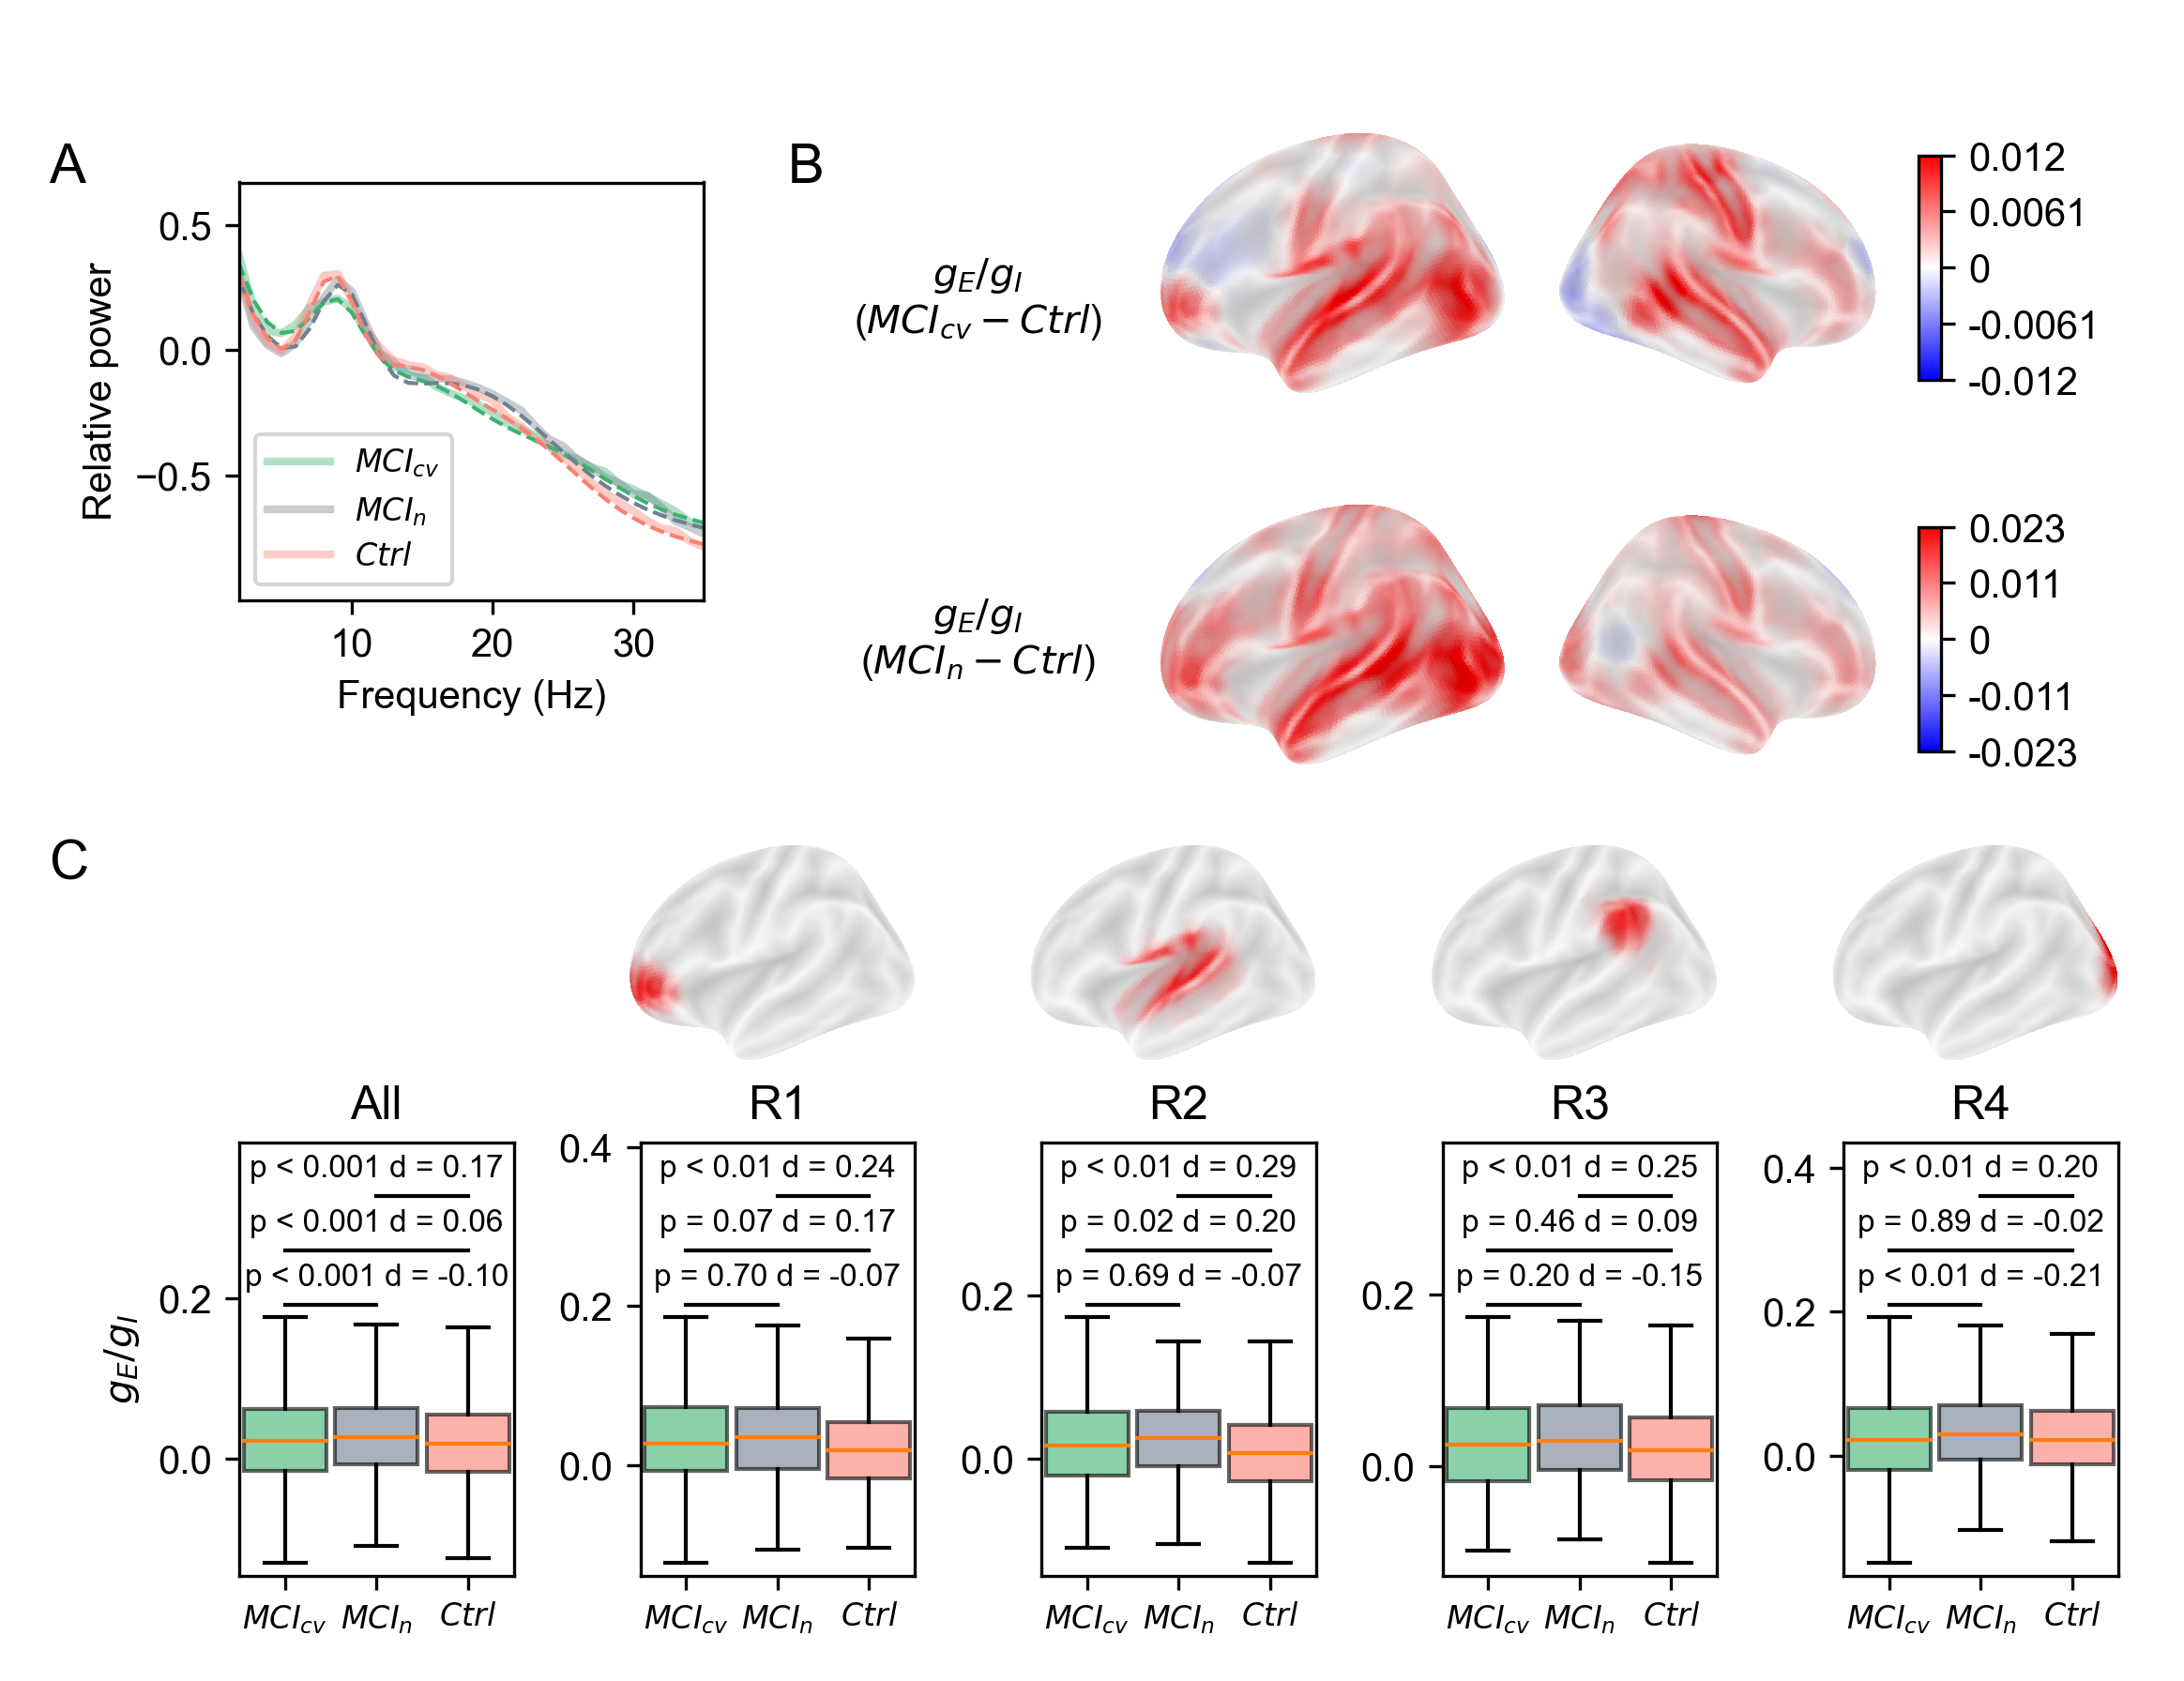

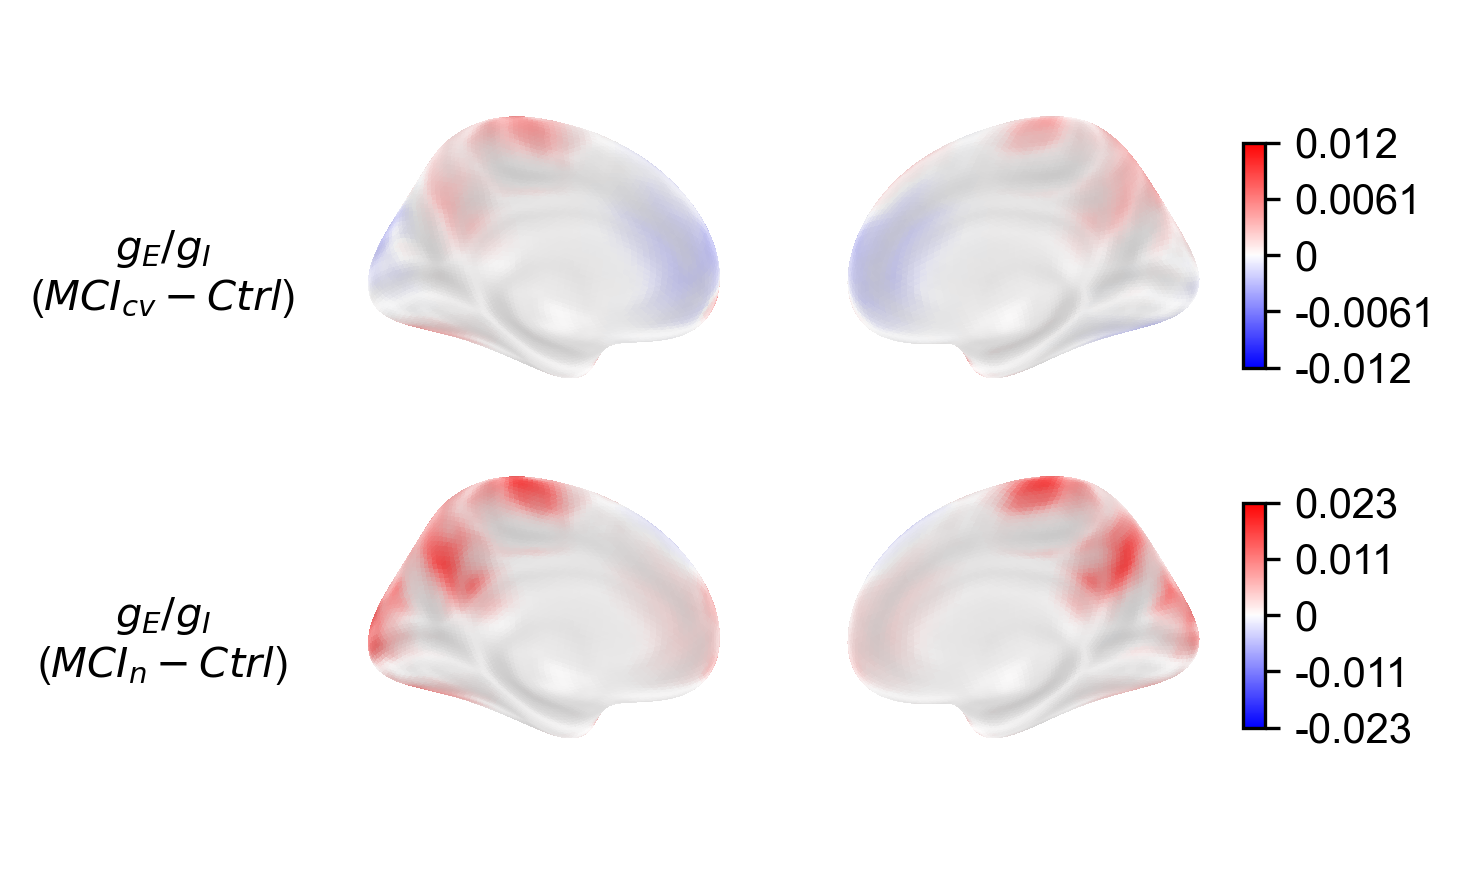

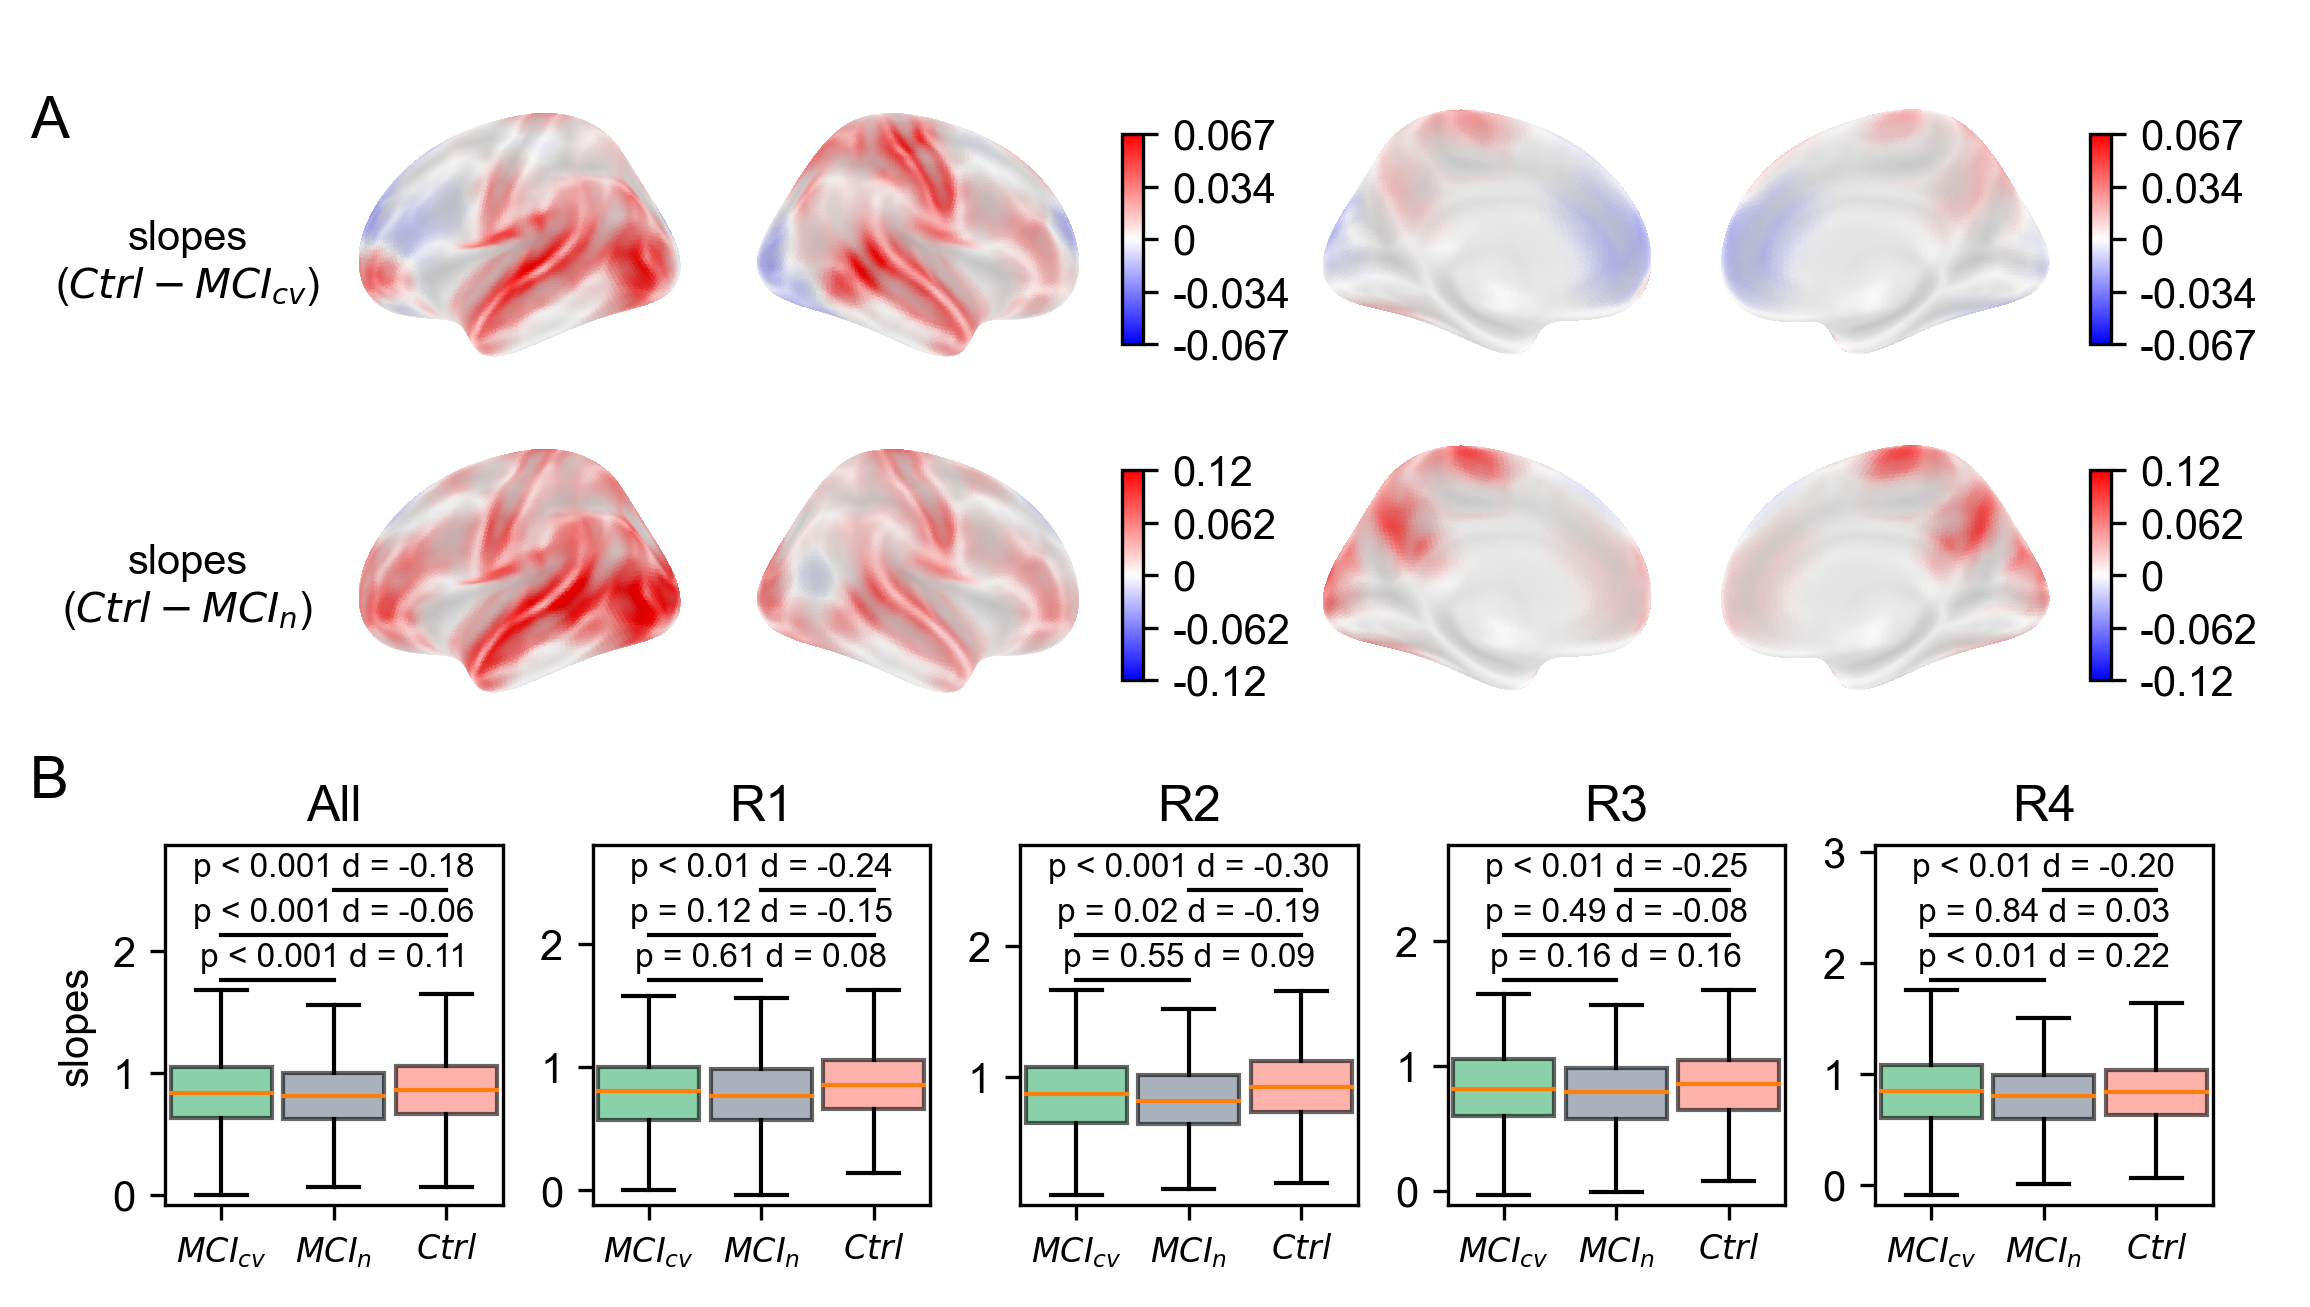

In [6]:
# Create figure 2
fig2 = plt.figure(figsize=[7.5,5.5], dpi=DPI)

# Create supplementary figure 2
figsup2 = plt.figure(figsize=[5,2.5], dpi=DPI)

# Create supplementary figure 3
figsup3 = plt.figure(figsize=[7.5,4], dpi=DPI)

# Labels of the panels of figure 2
Vax_labels1 = fig2.add_axes([0.,0.,1.,1.],xticks = [],xticklabels = [],
                                          yticks = [],yticklabels = [],
                                          frameon = False)
Vax_labels1.text(0.01,0.95,'A',fontsize = 14)
Vax_labels1.text(0.36,0.95,'B',fontsize = 14)
Vax_labels1.text(0.01,0.5,'C',fontsize = 14)

# Labels of the panels of supplementary figure 3
Vax_labels2 = figsup3.add_axes([0.,0.,1.,1.],xticks = [],xticklabels = [],
                                          yticks = [],yticklabels = [],
                                          frameon = False)
Vax_labels2.text(0.0,0.95,'A',fontsize = 14)
Vax_labels2.text(0.0,0.4,'B',fontsize = 14)

# Comparison of ROI-average power spectra
VaxA = fig2.add_axes([0.1,0.68,0.22,0.27])
VaxA.set_xlabel('Frequency (Hz)')
VaxA.set_ylabel('Relative power')
# VaxA.set_title('Power in MCI')

# Freq. range
freq_range = [np.where(fx >= fit_parameters['freq_range_FOOOF_fitting'][0])[0][0],
              np.where(fx >= fit_parameters['freq_range_FOOOF_fitting'][1])[0][0]]

# Averaged spectra
avg_MCI_conv_spectra = np.median(np.array([np.median(MCI_conv_spectra[ROI],axis = 0) for ROI in range(38)]),
                                 axis = 0)
avg_MCI_non_spectra = np.median(np.array([np.median(MCI_non_spectra[ROI],axis = 0) for ROI in range(38)]),
                                 axis = 0)
avg_control_spectra = np.median(np.array([np.median(control_spectra[ROI],axis = 0) for ROI in range(38)]),
                                 axis = 0)

# Spectral fittings
MCI_conv_spectrum_fit = tools.power_spectrum_fit(fx,avg_MCI_conv_spectra,fit_parameters)
MCI_non_spectrum_fit = tools.power_spectrum_fit(fx,avg_MCI_non_spectra,fit_parameters)
control_spectrum_fit = tools.power_spectrum_fit(fx,avg_control_spectra,fit_parameters)

# Plot power spectrum
VaxA.plot(fx[freq_range[0]:freq_range[1]],
          np.log10(avg_MCI_conv_spectra[freq_range[0]:freq_range[1]]),
          color = 'mediumseagreen', linewidth = 2.,alpha = 0.4,label = r'$MCI_{cv}$')
VaxA.plot(fx[freq_range[0]:freq_range[1]],
          np.log10(avg_MCI_non_spectra[freq_range[0]:freq_range[1]]),
          color = 'slategrey', linewidth = 2.,alpha = 0.4,label = r'$MCI_{n}$')
VaxA.plot(fx[freq_range[0]:freq_range[1]],
          np.log10(avg_control_spectra[freq_range[0]:freq_range[1]]),
          color = 'salmon', linewidth = 2.,alpha = 0.4,label = r'$Ctrl$')

# Plot FOOOF fitting
VaxA.plot(fx[freq_range[0]:freq_range[1]],
          np.log10(MCI_conv_spectrum_fit[1][freq_range[0]:freq_range[1]]),
          color = 'mediumseagreen',linestyle='--',linewidth=1.)
VaxA.plot(fx[freq_range[0]:freq_range[1]],
          np.log10(MCI_non_spectrum_fit[1][freq_range[0]:freq_range[1]]),
          color = 'slategrey',linestyle='--',linewidth=1.)
VaxA.plot(fx[freq_range[0]:freq_range[1]],
          np.log10(control_spectrum_fit[1][freq_range[0]:freq_range[1]]),
          color = 'salmon',linestyle='--',linewidth=1.)

# Legend, limits and xticks
VaxA.legend(fontsize = 8, loc = 'lower left')
VaxA.set_xlim([2,35])
VaxA.set_xticks([10,20,30])
VaxA.set_xticklabels(['10','20','30'])

# Brain surface plots of Fig. 2
VaxB1 = fig2.add_axes([0.5,0.75,0.23,0.29],projection = '3d')
VaxB2 = fig2.add_axes([0.7,0.75,0.23,0.29],projection = '3d')
VaxB3 = fig2.add_axes([0.5,0.51,0.23,0.29],projection = '3d')
VaxB4 = fig2.add_axes([0.7,0.51,0.23,0.29],projection = '3d')

# Brain surface plots of Supplementary figure 3
VaxA1 = figsup3.add_axes([0.1,0.69,0.23,0.35],projection = '3d')
VaxA2 = figsup3.add_axes([0.29,0.69,0.23,0.35],projection = '3d')
VaxA3 = figsup3.add_axes([0.1,0.41,0.23,0.35],projection = '3d')
VaxA4 = figsup3.add_axes([0.29,0.41,0.23,0.35],projection = '3d')
VaxA5 = figsup3.add_axes([0.53,0.69,0.23,0.35],projection = '3d')
VaxA6 = figsup3.add_axes([0.72,0.69,0.23,0.35],projection = '3d')
VaxA7 = figsup3.add_axes([0.53,0.41,0.23,0.35],projection = '3d')
VaxA8 = figsup3.add_axes([0.72,0.41,0.23,0.35],projection = '3d')

# Brain surface plots of Supplementary figure 2
VaxA1b = figsup2.add_axes([0.17,0.48,0.4,0.6],projection = '3d')
VaxA2b = figsup2.add_axes([0.5,0.48,0.4,0.6],projection = '3d')
VaxA3b = figsup2.add_axes([0.17,0.0,0.4,0.6],projection = '3d')
VaxA4b = figsup2.add_axes([0.5,0.0,0.4,0.6],projection = '3d')

# Titles and limits of brain surface plots of Fig. 2
VaxB1B2 = fig2.add_axes([0.45,0.7,0.1,0.35],xticks = [],yticks = [],frameon = False)
VaxB3B4 = fig2.add_axes([0.45,0.48,0.1,0.35],xticks = [],yticks = [],frameon = False)
VaxB1B2.set_xlim([0,1]),VaxB1B2.set_ylim([0,1])
VaxB3B4.set_xlim([0,1]),VaxB3B4.set_ylim([0,1])
VaxB1B2.text(0,0.5,r'$g_E/g_I$''\n('+r'$MCI_{cv}-Ctrl$'+')',
            horizontalalignment = 'center',verticalalignment = 'center')
VaxB3B4.text(0,0.5,r'$g_E/g_I$''\n('+r'$MCI_{n}-Ctrl$'+')',
            horizontalalignment = 'center',verticalalignment = 'center')

# Titles and limits of brain surface plots of Supplementary figure 3
VaxA1A2 = figsup3.add_axes([0.07,0.67,0.1,0.35],xticks = [],yticks = [],frameon = False)
VaxA3A4 = figsup3.add_axes([0.07,0.4,0.1,0.35],xticks = [],yticks = [],frameon = False)
VaxA1A2.set_xlim([0,1]),VaxA1A2.set_ylim([0,1])
VaxA3A4.set_xlim([0,1]),VaxA3A4.set_ylim([0,1])
VaxA1A2.text(0,0.5,'slopes\n('+r'$Ctrl-MCI_{cv}$'+')',
            horizontalalignment = 'center',verticalalignment = 'center')
VaxA3A4.text(0,0.5,'slopes\n('+r'$Ctrl-MCI_{n}$'+')',
            horizontalalignment = 'center',verticalalignment = 'center')

# Titles and limits of brain surface plots of Supplementary figure 2
VaxA1A2b = figsup2.add_axes([0.12,0.58,0.1,0.35],xticks = [],yticks = [],frameon = False)
VaxA3A4b = figsup2.add_axes([0.12,0.09,0.1,0.35],xticks = [],yticks = [],frameon = False)
VaxA1A2b.set_xlim([0,1]),VaxA1A2b.set_ylim([0,1])
VaxA3A4b.set_xlim([0,1]),VaxA3A4b.set_ylim([0,1])
VaxA1A2b.text(0,0.5,r'$g_E/g_I$''\n('+r'$MCI_{cv}-Ctrl$'+')',
            horizontalalignment = 'center',verticalalignment = 'center')
VaxA3A4b.text(0,0.5,r'$g_E/g_I$''\n('+r'$MCI_{n}-Ctrl$'+')',
            horizontalalignment = 'center',verticalalignment = 'center')

# Load regression model
model =  pickle.load(open("../regression_coefficients/poly_regression_model","rb") )

# E/I predictions
MCI_conv_preds = [model(np.array(MCI_conv_slopes[roi])) for roi in range(38)]
MCI_non_preds = [model(np.array(MCI_non_slopes[roi])) for roi in range(38)]
control_preds = [model(np.array(control_slopes[roi])) for roi in range(38)]

# Differences in means of predictions
diff_conv_preds = [np.mean(MCI_conv_preds[roi]) - np.mean(control_preds[roi]) for roi in range(38)]
diff_non_preds = [np.mean(MCI_non_preds[roi]) - np.mean(control_preds[roi]) for roi in range(38)]
vmax_conv_preds = np.max(np.max(np.abs(diff_conv_preds)))
vmax_non_preds = np.max(np.max(np.abs(diff_non_preds)))
# vmax_preds = np.max((vmax_conv_preds,vmax_non_preds))

# Differences in means of slopes
diff_conv_slopes = [np.mean(control_slopes[roi]) - np.mean(MCI_conv_slopes[roi]) for roi in range(38)]
diff_non_slopes = [np.mean(control_slopes[roi]) - np.mean(MCI_non_slopes[roi]) for roi in range(38)]
vmax_conv_slopes = np.max(np.max(np.abs(diff_conv_slopes)))
vmax_non_slopes = np.max(np.max(np.abs(diff_non_slopes)))
# vmax_slopes = np.max((vmax_conv_slopes,vmax_non_slopes))

# Map predictions and slopes to brain surfaces
# Fig. 2
# Left hemi.
tools.plot_MEG_volumes(diff_conv_preds,fig2,VaxB1,'left',vmax_conv_preds,'lateral')
tools.plot_MEG_volumes(diff_non_preds,fig2,VaxB3,'left',vmax_non_preds,'lateral')

# Right hemi.
tools.plot_MEG_volumes(diff_conv_preds,fig2,VaxB2,'right',vmax_conv_preds,'lateral')
tools.plot_MEG_volumes(diff_non_preds,fig2,VaxB4,'right',vmax_non_preds,'lateral')

# Supplementary figure 3
# Left hemi.
tools.plot_MEG_volumes(diff_conv_slopes,figsup3,VaxA1,'left',vmax_conv_slopes,'lateral')
tools.plot_MEG_volumes(diff_non_slopes,figsup3,VaxA3,'left',vmax_non_slopes,'lateral')

# Right hemi.
tools.plot_MEG_volumes(diff_conv_slopes,figsup3,VaxA2,'right',vmax_conv_slopes,'lateral')
tools.plot_MEG_volumes(diff_non_slopes,figsup3,VaxA4,'right',vmax_non_slopes,'lateral')

# Left hemi.
tools.plot_MEG_volumes(diff_conv_slopes,figsup3,VaxA5,'left',vmax_conv_slopes,'medial')
tools.plot_MEG_volumes(diff_non_slopes,figsup3,VaxA7,'left',vmax_non_slopes,'medial')

# Right hemi.
tools.plot_MEG_volumes(diff_conv_slopes,figsup3,VaxA6,'right',vmax_conv_slopes,'medial')
tools.plot_MEG_volumes(diff_non_slopes,figsup3,VaxA8,'right',vmax_non_slopes,'medial')

# Supplementary figure 2
# Left hemi.
tools.plot_MEG_volumes(diff_conv_preds,figsup2,VaxA1b,'left',vmax_conv_preds,'medial')
tools.plot_MEG_volumes(diff_non_preds,figsup2,VaxA3b,'left',vmax_non_preds,'medial')

# Right hemi.
tools.plot_MEG_volumes(diff_conv_preds,figsup2,VaxA2b,'right',vmax_conv_preds,'medial')
tools.plot_MEG_volumes(diff_non_preds,figsup2,VaxA4b,'right',vmax_non_preds,'medial')

# Brain surfaces that show selected ROIs used in boxplots
Vaxbr1 = fig2.add_axes([0.25,0.33,0.2,0.24],projection = '3d')
Vaxbr2 = fig2.add_axes([0.44,0.33,0.2,0.24],projection = '3d')
Vaxbr3 = fig2.add_axes([0.63,0.33,0.2,0.24],projection = '3d')
Vaxbr4 = fig2.add_axes([0.82,0.33,0.2,0.24],projection = '3d')

# Plot selected ROIs
ROIs = np.zeros(38)
ROIs[30] = 1
tools.plot_MEG_volumes(ROIs,fig2,Vaxbr1,'left',1.,'lateral',False)
ROIs = np.zeros(38)
ROIs[6] = 1
tools.plot_MEG_volumes(ROIs,fig2,Vaxbr2,'left',1.,'lateral',False)
ROIs = np.zeros(38)
ROIs[[20]] = 1
tools.plot_MEG_volumes(ROIs,fig2,Vaxbr3,'left',1.,'lateral',False)
ROIs = np.zeros(38)
ROIs[[0,24]] = 1
tools.plot_MEG_volumes(ROIs,fig2,Vaxbr4,'left',1.,'lateral',False)

# Pooling of slopes and E/I predictions across different brain regions
# Panels of E/I predictions
VaxC1 = fig2.add_axes([0.1,0.05,0.13,0.28])
VaxC2 = fig2.add_axes([0.29,0.05,0.13,0.28])
VaxC3 = fig2.add_axes([0.48,0.05,0.13,0.28])
VaxC4 = fig2.add_axes([0.67,0.05,0.13,0.28])
VaxC5 = fig2.add_axes([0.86,0.05,0.13,0.28])
all_VaxC = [VaxC1,VaxC2,VaxC3,VaxC4,VaxC5]

VaxC1.set_title('All')
VaxC2.set_title('R1')
VaxC3.set_title('R2')
VaxC4.set_title('R3')
VaxC5.set_title('R4')
VaxC1.set_ylabel(r'$g_E/g_I$')

# Panels of slopes
VaxB1b = figsup3.add_axes([0.06,0.06,0.15,0.3])
VaxB2b = figsup3.add_axes([0.25,0.06,0.15,0.3])
VaxB3b = figsup3.add_axes([0.44,0.06,0.15,0.3])
VaxB4b = figsup3.add_axes([0.63,0.06,0.15,0.3])
VaxB5b = figsup3.add_axes([0.82,0.06,0.15,0.3])
all_VaxBb = [VaxB1b,VaxB2b,VaxB3b,VaxB4b,VaxB5b]

VaxB1b.set_title('All')
VaxB2b.set_title('R1')
VaxB3b.set_title('R2')
VaxB4b.set_title('R3')
VaxB5b.set_title('R4')
VaxB1b.set_ylabel('slopes')

for br in range(5):
    # All
    if br == 0:
        MCI_conv_subset = MCI_conv_slopes
        MCI_non_subset = MCI_non_slopes
        control_subset = control_slopes

    # Frontal
    if br == 1:
        MCI_conv_subset = [MCI_conv_slopes[30]]
        MCI_non_subset = [MCI_non_slopes[30]]
        control_subset = [control_slopes[30]]

    # Temporal
    if br == 2:
        MCI_conv_subset = [MCI_conv_slopes[6]]
        MCI_non_subset = [MCI_non_slopes[6]]
        control_subset = [control_slopes[6]]

    # Parietal
    if br == 3:
        MCI_conv_subset = [MCI_conv_slopes[20]]
        MCI_non_subset = [MCI_non_slopes[20]]
        control_subset = [control_slopes[20]]

    # Occipital
    if br == 4:
        MCI_conv_subset = [MCI_conv_slopes[0],
                           MCI_conv_slopes[24]]
        MCI_non_subset = [MCI_non_slopes[0],
                          MCI_non_slopes[24]]
        control_subset = [control_slopes[0],
                          control_slopes[24]]

    # E/I predictions
    MCI_conv_preds = model(np.hstack(np.array(MCI_conv_subset)))
    MCI_non_preds = model(np.hstack(np.array(MCI_non_subset)))
    control_preds = model(np.hstack(np.array(control_subset)))

    # Boxplots of E/I predictions
    bplot1 = all_VaxC[br].boxplot(x = MCI_conv_preds,
                                    positions = [0],widths = [0.9],
                                    patch_artist=True,showfliers=False)
    bplot2 = all_VaxC[br].boxplot(x = MCI_non_preds,
                                    positions = [1],widths = [0.9],
                                    patch_artist=True,showfliers=False)
    bplot3 = all_VaxC[br].boxplot(x = control_preds,
                                    positions = [2],widths = [0.9],
                                    patch_artist=True,showfliers=False)

    # Boxplots of slopes
    bplot4 = all_VaxBb[br].boxplot(x = np.hstack(np.array(MCI_conv_subset)),
                                    positions = [0],widths = [0.9],
                                    patch_artist=True,showfliers=False)
    bplot5 = all_VaxBb[br].boxplot(x = np.hstack(np.array(MCI_non_subset)),
                                    positions = [1],widths = [0.9],
                                    patch_artist=True,showfliers=False)
    bplot6 = all_VaxBb[br].boxplot(x = np.hstack(np.array(control_subset)),
                                    positions = [2],widths = [0.9],
                                    patch_artist=True,showfliers=False)

    # Colors
    for patch in bplot1['boxes']:
        patch.set_facecolor('mediumseagreen')
        patch.set_alpha(0.6)
    for patch in bplot2['boxes']:
        patch.set_facecolor('slategrey')
        patch.set_alpha(0.6)
    for patch in bplot3['boxes']:
        patch.set_facecolor('salmon')
        patch.set_alpha(0.6)
    for patch in bplot4['boxes']:
        patch.set_facecolor('mediumseagreen')
        patch.set_alpha(0.6)
    for patch in bplot5['boxes']:
        patch.set_facecolor('slategrey')
        patch.set_alpha(0.6)
    for patch in bplot6['boxes']:
        patch.set_facecolor('salmon')
        patch.set_alpha(0.6)

    # Labels
    all_VaxC[br].set_xticks([0,1,2])
    all_VaxC[br].set_xticklabels([r'$MCI_{cv}$',r'$MCI_{n}$',r'$Ctrl$'],
                                fontsize = 8)
    all_VaxBb[br].set_xticks([0,1,2])
    all_VaxBb[br].set_xticklabels([r'$MCI_{cv}$',r'$MCI_{n}$',r'$Ctrl$'],
                                fontsize = 8)

    # Statistical tests
    tools.tukeyhsd([ MCI_conv_preds,
                     MCI_non_preds,
                     control_preds],
                     all_VaxC[br])
    tools.tukeyhsd([np.hstack(np.array(MCI_conv_subset)),
                    np.hstack(np.array(MCI_non_subset)),
                    np.hstack(np.array(control_subset))],
                    all_VaxBb[br])